In [1]:
import sys, os, re
print("Kernel Python:", sys.executable)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import random

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /work3/s232958/envs/esm_cuda/bin/python


first you need to run `02_ESMC_encoding_some_PDB_seqs.ipynb` to generate ESM_C encodings for some of the proteins from PPint

In [2]:
PPint_encodings_path = "/work3/s232958/data/PPint_DB/esmif_embeddings_noncanonical"
PPint_DB_encodings_files = os.listdir(PPint_encodings_path)
PPint_DB_encodings_files = random.sample(PPint_DB_encodings_files, 1000) 
PPint_DB_embedings = [np.load(os.path.join(PPint_encodings_path, f)) for f in PPint_DB_encodings_files]
# PPint_DB_embedings = [np.load(os.path.join(PPint_encodings_path, f)) for f in PPint_DB_encodings_files]

In [3]:
meta_Df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")
targets = meta_Df.target_id_mod.unique()

meta_binders_encodings_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_binders"
meta_targets_encodings_path = "/work3/s232958/data/meta_analysis/esmif_embeddings_targets"

meta_binders_encodings_files = sorted(os.listdir(meta_binders_encodings_path))
meta_targets_encodings_files = sorted(os.listdir(meta_targets_encodings_path))

meta_binders_files = random.sample(meta_binders_encodings_files, 1000) 

meta_binders_embedings = [np.load(os.path.join(meta_binders_encodings_path, f)) for f in meta_binders_files]
meta_targets_embedings = [np.load(os.path.join(meta_targets_encodings_path, f)) for f in meta_targets_encodings_files]

# meta_binders_embedings = [np.load(os.path.join(meta_encodings_path, f)) for f in meta_binders_files]
# meta_targets_embedings = [np.load(os.path.join(meta_encodings_path, f)) for f in meta_targets_files]

In [4]:
# boltzgen_Df = pd.read_csv("/work3/s232958/data/boltzgen/boltzgen_df_filtered.csv")
# targets = boltzgen_Df.target_id.unique()

# boltzgen_encodings_path = "/work3/s232958/data/boltzgen/embeddings_esmC"
# boltzgen_encodings_files = sorted(os.listdir(boltzgen_encodings_path))

# targets_files, binders_files = [], []
# for file in boltzgen_encodings_files:
#     if file.split(".")[0] in targets:
#         targets_files.append(file)
#     else:
#         binders_files.append(file)
# print(len(binders_files), len(targets_files))

# boltzgen_binders_embedings = [np.load(os.path.join(boltzgen_encodings_path, f))[0] for f in binders_files]
# boltzgen_targets_embedings = [np.load(os.path.join(boltzgen_encodings_path, f))[0] for f in targets_files]

# groups = [fname.split("_")[0] for fname in binders_files]

In [5]:
# bindcraft_Df = pd.read_csv("/work3/s232958/data/bindcraft/bindcraft_with_target_seq.csv")
# targets = bindcraft_Df.target_id.unique()

# bindcraft_encodings_path = "/work3/s232958/data/bindcraft/embeddings_esmC"
# bindcraft_encodings_files = sorted(os.listdir(bindcraft_encodings_path))

# targets_files, binders_files = [], []
# for file in bindcraft_encodings_files:
#     if file.split(".")[0] in targets:
#         targets_files.append(file)
#     else:
#         binders_files.append(file)
# print(len(binders_files), len(targets_files))

# bindcraft_binders_embedings = [np.load(os.path.join(bindcraft_encodings_path, f))[0] for f in binders_files]
# bindcraft_targets_embedings = [np.load(os.path.join(bindcraft_encodings_path, f))[0] for f in targets_files]

# groups = [fname.split("_")[0] for fname in binders_files]

In [6]:
print(f"# of PPint embeddings in the PCA plot: {len(PPint_DB_embedings)}")
print(f"# of meta-analysis binders embeddings in the PCA plot: {len(meta_binders_embedings)}")
print(f"# of meta-analysis targets embeddings in the PCA plot: {len(meta_targets_embedings)}")
# print(f"# of Boltzgen_binders embeddings in the PCA plot: {len(boltzgen_binders_embedings)}")
# print(f"# of Boltzgen_targets embeddings in the PCA plot: {len(boltzgen_targets_embedings)}")
# print(f"# of Boltzgen_binders embeddings in the PCA plot: {len(bindcraft_binders_embedings)}")
# print(f"# of Boltzgen_targets embeddings in the PCA plot: {len(bindcraft_targets_embedings)}")

# of PPint embeddings in the PCA plot: 1000
# of meta-analysis binders embeddings in the PCA plot: 1000
# of meta-analysis targets embeddings in the PCA plot: 16


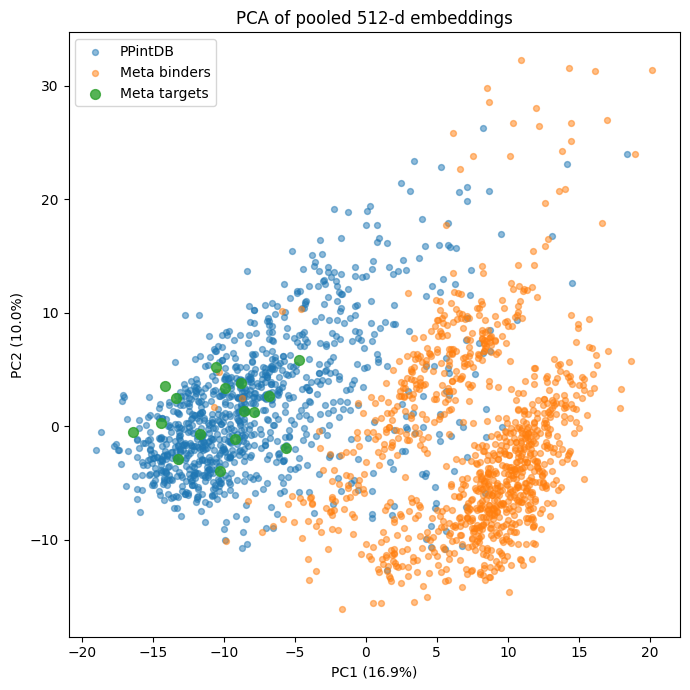

In [9]:
# 1) Pool per-sample (mean over residues) -> (Ni, 512)
pooled_PPintDB       = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)        # (N1, 512)
pooled_meta_binders  = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)    # (N2, 512)
pooled_meta_targets  = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)    # (N3, 512)

# 2) Standardize jointly (important!)
X_all = np.vstack([pooled_PPintDB, pooled_meta_binders, pooled_meta_targets])  # (N1+N2+N3, 512)
X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]

Z_PPintDB       = Z_all[:N1]
Z_meta_binders  = Z_all[N1:N1+N2]
Z_meta_targets  = Z_all[N1+N2:N1+N2+N3]   # or simply Z_all[N1+N2:]

# 5) Plot
plt.figure(figsize=(7,7))
plt.scatter(Z_PPintDB[:,0],      Z_PPintDB[:,1],      s=18, alpha=0.5, label="PPintDB",        marker='o')
plt.scatter(Z_meta_binders[:,0], Z_meta_binders[:,1], s=18, alpha=0.5, label="Meta binders",   marker='o')
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=50, alpha=0.8, label="Meta targets",   marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 512-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB            = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)           # (N1, 1152)
pooled_boltzgen_binders   = np.stack([arr.mean(axis=0) for arr in boltzgen_binders_embedings], axis=0)   # (N2, 1152)
pooled_boltzgen_targets   = np.stack([arr.mean(axis=0) for arr in boltzgen_targets_embedings], axis=0)   # (N3, 1152)
pooled_meta_binders       = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)       # (N4, 1152)
pooled_meta_targets       = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)       # (N5, 1152)
pooled_bindcraft_binders   = np.stack([arr.mean(axis=0) for arr in bindcraft_binders_embedings], axis=0)   # (N2, 1152)
pooled_bindcraft_targets   = np.stack([arr.mean(axis=0) for arr in bindcraft_targets_embedings], axis=0)   # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([
    pooled_PPintDB,
    pooled_meta_binders,
    pooled_meta_targets,
    pooled_boltzgen_binders,
    pooled_boltzgen_targets,
    pooled_bindcraft_binders,
    pooled_bindcraft_targets
]) 

X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3+N4+N5, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]
N4 = pooled_boltzgen_binders.shape[0]
N5 = pooled_boltzgen_targets.shape[0]
N6 = pooled_bindcraft_binders.shape[0]
N7 = pooled_bindcraft_targets.shape[0]

Z_PPintDB            = Z_all[:N1]
Z_meta_binders       = Z_all[N1:N1+N2]
Z_meta_targets       = Z_all[N1+N2:N1+N2+N3]  # remaining rows
Z_boltzgen_binders   = Z_all[N1+N2+N3:N1+N2+N3+N4]
Z_boltzgen_targets   = Z_all[N1+N2+N3+N4:N1+N2+N3+N4+N5]
Z_bindcraft_binders   = Z_all[N1+N2+N3+N4+N5:N1+N2+N3+N4+N5+N6]
Z_bindcraft_targets   = Z_all[N1+N2+N3+N4+N5+N6:N1+N2+N3+N4+N5+N6+N7]


# 5) Plot
plt.figure(figsize=(7, 7))
plt.scatter(Z_PPintDB[:, 0],          Z_PPintDB[:, 1],          s=18, alpha=0.5, label="PPintDB",           marker='o')
plt.scatter(Z_meta_binders[:, 0],     Z_meta_binders[:, 1],     s=18, alpha=0.5, label="Meta binders",      marker='o')
plt.scatter(Z_meta_targets[:, 0],     Z_meta_targets[:, 1],     s=50, alpha=0.8, label="Meta targets",      marker='o')
plt.scatter(Z_boltzgen_binders[:, 0], Z_boltzgen_binders[:, 1], s=18, alpha=0.7, label="Boltzgen binders",  marker='o')
plt.scatter(Z_boltzgen_targets[:, 0], Z_boltzgen_targets[:, 1], s=50, alpha=0.8, label="Boltzgen targets",  marker='o')
plt.scatter(Z_bindcraft_binders[:, 0], Z_bindcraft_binders[:, 1], s=18, alpha=0.7, label="Bindcraft binders",  marker='o')
plt.scatter(Z_bindcraft_targets[:, 0], Z_bindcraft_targets[:, 1], s=50, alpha=0.8, label="Bindcraft targets",  marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings (PPint, Boltzgen, Meta)")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'boltzgen_binders_embedings' is not defined